# Copula Revisited

Focus on lower frequency data. 

The whole procedure is set up in the `paired.py` module in the `rosettastone.algo.arbitrage` package.  

# Result
See `doc/copula_result.md`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rosettastone.algos.arbitrage.paired import get_paired_data, Pairing
from rosettastone.algos.arbitrage.copulae import EmpProbIntegralTransform as F
from rosettastone.algos.arbitrage.copulae import BivariateCopula

In [2]:
contract_pair = 'IH:df0-IH:df1'
freq = '1min'
print(f'Pairing {contract_pair}')
contract_1, contract_2 = contract_pair.split('-')
[contract_name_1, df_kind_1], [contract_name_2, df_kind_2] = contract_1.split(':'), contract_2.split(':')
df_1, df_2 = get_paired_data(contract_name_1, contract_name_2, freq=freq, df_kind_1=df_kind_1, df_kind_2=df_kind_2)


Pairing IH:df0-IH:df1
d1 and d2 are of the same shape?  True


In [3]:
df_1

,market_time,code,open,high,low,close,open_interest,volume,amount
0,2022-08-01 09:31:00.000,IH2208,2779.8,2779.8,2767.6,2768.2,39972,1171,974487540
1,2022-08-01 09:32:00.000,IH2208,2768.2,2768.2,2763.2,2766.0,39630,872,723390900
2,2022-08-01 09:33:00.000,IH2208,2766.0,2770.6,2765.0,2769.2,39340,479,397781700
3,2022-08-01 09:34:00.000,IH2208,2769.2,2769.6,2765.2,2765.8,39145,316,262396800
4,2022-08-01 09:35:00.000,IH2208,2765.8,2771.0,2764.6,2771.0,38959,323,268170360
...,...,...,...,...,...,...,...,...,...
7357,2022-09-14 14:56:00.200,IH2209,2750.6,2751.2,2750.4,2750.8,42396,140,115535520
7358,2022-09-14 14:57:00.200,IH2209,2750.8,2751.4,2750.4,2751.0,42418,138,113890560
7359,2022-09-14 14:58:00.200,IH2209,2751.0,2751.0,2749.8,2750.2,42412,187,154289040
7360,2022-09-14 14:59:00.200,IH2209,2750.2,2750.6,2749.6,2750.0,42435,215,177380520


In [4]:
# This cell  is for sequential run 
# df_1.to_csv('IH.1min.df0.csv', sep=',', index=False)
# df_2.to_csv('IH.1min.df1.csv', sep=',', index=False)

In [5]:
aPair = Pairing(df_1, df_2)
aPair.train_test_split(test_size=0.3)

number of days in the training set: 21
number of days in the test set: 10


In [6]:
x_file = f'trained.emp.{contract_pair}.{freq}.x.pkl'
y_file = f'trained.emp.{contract_pair}.{freq}.y.pkl'
aPair.get_uniform_returns(save_f=True, f_name_x=x_file, f_name_y=y_file)

In [7]:
ux, uy = aPair.u_x_in_sample, aPair.u_y_in_sample

### Dependency Structure: Original Scale 

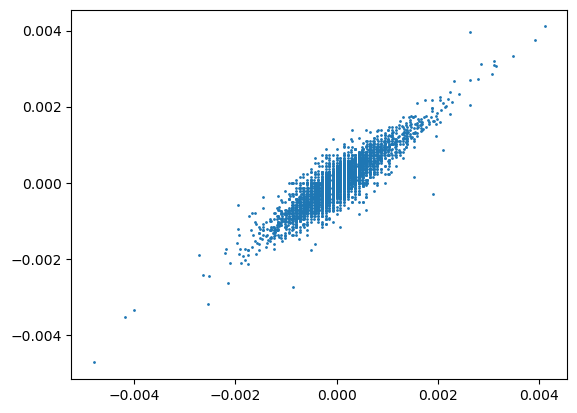

In [8]:
ori_x, ori_y = aPair.returns_x_training, aPair.returns_y_training
plt.scatter(ori_x, ori_y, s=1)

### Dependency Structure: Uniform Scale

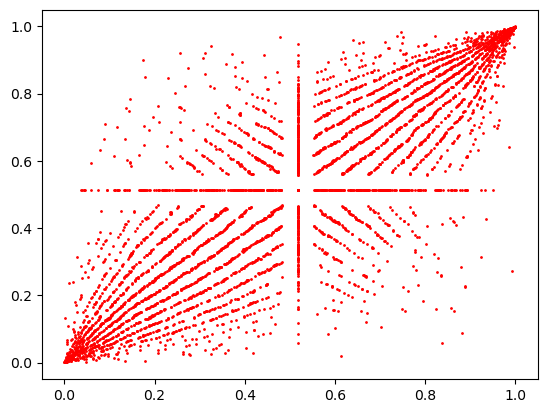

In [9]:
plt.scatter(ux, uy, s=1, c='r')

#### Uniform distribution

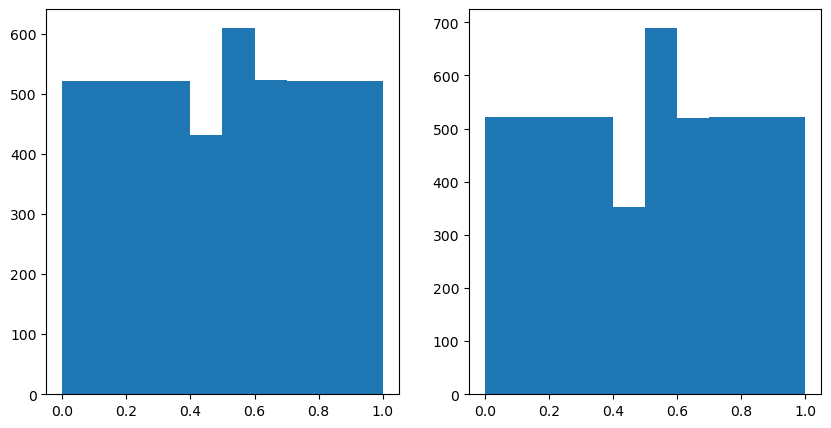

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(ux); axes[1].hist(uy);

### Dependency Structure: Z-Scale

Some examples from paper are
![Example Copulas Contours](./examplecopulas.png)

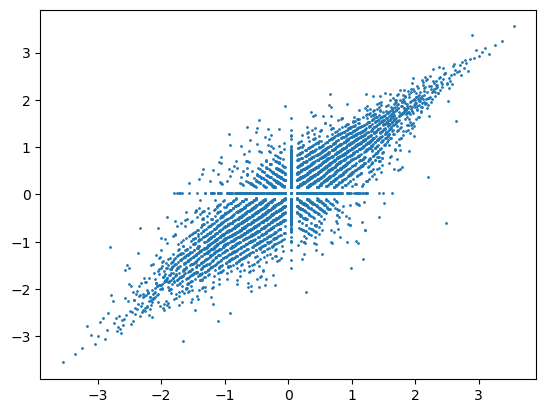

In [11]:
from scipy.stats import norm
zx, zy = norm.ppf(ux), norm.ppf(uy)
plt.scatter(zx, zy, s=1)

### Kernel density estimation: using Guassian KDE

In [12]:
from scipy.stats import gaussian_kde
kernel = gaussian_kde(np.vstack([zx, zy]))
zx_min,zx_max = zx.min(), zx.max()
zy_min,zy_max = zy.min(), zy.max()
zxx, zyy = np.mgrid[zx_min:zx_max:100j, zy_min:zy_max:100j]
contours = np.reshape(kernel(np.vstack([zxx.ravel(), zyy.ravel()])), zxx.shape)

Text(0.5, 1.0, 'Z-scale Dependency, IH:df0-IH:df1, frequency:1min')

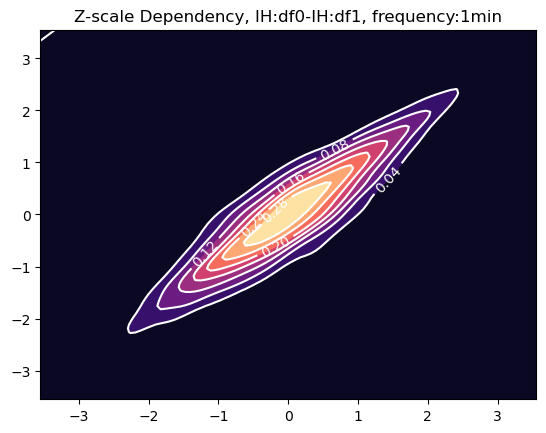

In [13]:
fig,ax = plt.subplots()
cfset = ax.contourf(zxx, zyy, contours, cmap='magma')
cset = ax.contour(zxx, zyy, contours, colors='w')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_title(f'Z-scale Dependency, {contract_pair}, frequency:{freq}')

### Check fitted kernel versus existing 

In [14]:
aPair.get_misprice_index(method='copula')
cop = aPair.cop
print(f'kendall tau: {cop.cop.tau}')

Bivariate Copula Fitting Result
<pyvinecopulib.Bicop>
BB7 180°, parameters = 2.73511
2.65288
kendall tau: 0.6610492406847065


In [15]:
# # save fitted copula 
# cop_name = f'trained.copula.{contract_pair}.{freq}.json'
# cop.cop.to_json(cop_name)

# # load fitted copula model
# import pyvinecopulib as pv 
# a_new_cop = pv.Bicop(cop_name)
# print(a_new_cop)


## NEXT: Different Time Frames


- [ ] minute, hours
- [x] different contracts (ratio needed)

### First:  signal correlation with spread price

**Correlation** between pairs is strong, but **not so for our cumulative misprice index** 

In [16]:
np.corrcoef(aPair.df_1['close'].to_numpy(), aPair.df_2['close'].to_numpy(), rowvar=False,dtype=np.float64)

array([[1.        , 0.99853738],
       [0.99853738, 1.        ]])

In [17]:
spread = aPair.df_1['close'].to_numpy(dtype=np.float64) - aPair.df_2['close'].to_numpy(dtype=np.float64)

In [18]:
np.corrcoef(spread, aPair.flag_XY, rowvar=False,dtype=np.float64)

array([[1.        , 0.07341475],
       [0.07341475, 1.        ]])

In [19]:
np.corrcoef(spread, aPair.flag_YX, rowvar=False,dtype=np.float64)

array([[ 1.        , -0.09671623],
       [-0.09671623,  1.        ]])

Text(0.5, 0.98, 'Correlation between spread and flag, IH:df0-IH:df1, frequency:1min')

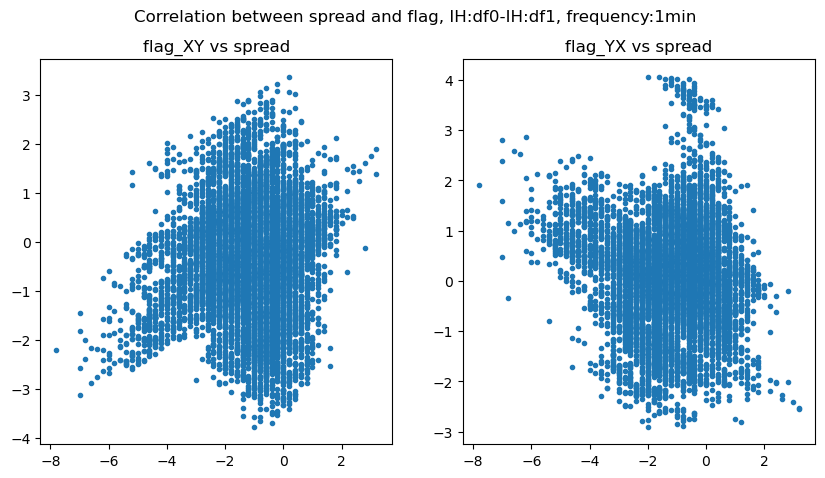

In [20]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(spread, aPair.flag_XY, '.')
ax[0].set_title('flag_XY vs spread')
ax[1].plot(spread, aPair.flag_YX, '.')
ax[1].set_title('flag_YX vs spread')
plt.suptitle(f'Correlation between spread and flag, {contract_pair}, frequency:{freq}')

In [21]:
np.corrcoef(aPair.flag_XY, aPair.flag_YX, rowvar=False,dtype=np.float64)

array([[1.        , 0.04875857],
       [0.04875857, 1.        ]])

Text(0.5, 0.98, 'Correlation between flag_XY and flag_YX, IH:df0-IH:df1, frequency:1min')

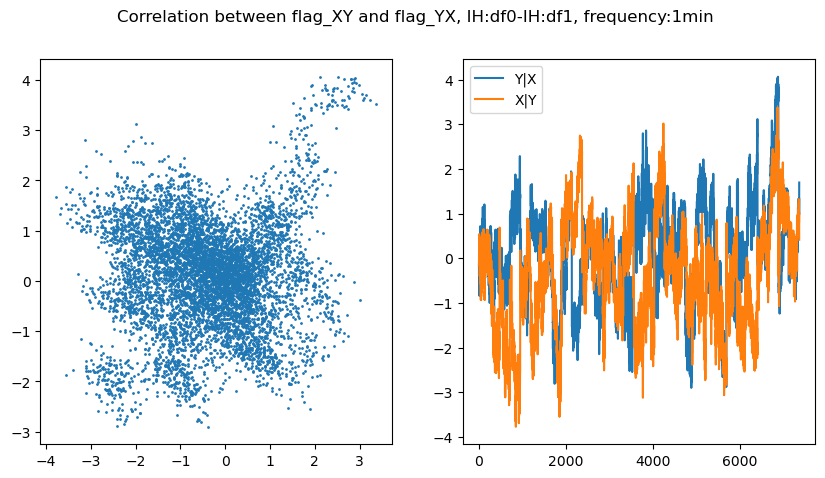

In [22]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(aPair.flag_XY, aPair.flag_YX, s=1)
ax[1].plot(aPair.flag_YX, label='Y|X')
ax[1].plot(aPair.flag_XY, label='X|Y')
ax[1].legend()
plt.suptitle(f'Correlation between flag_XY and flag_YX, {contract_pair}, frequency:{freq}')

Text(0.5, 0.98, 'spread and flag, IH:df0-IH:df1, frequency:1min')

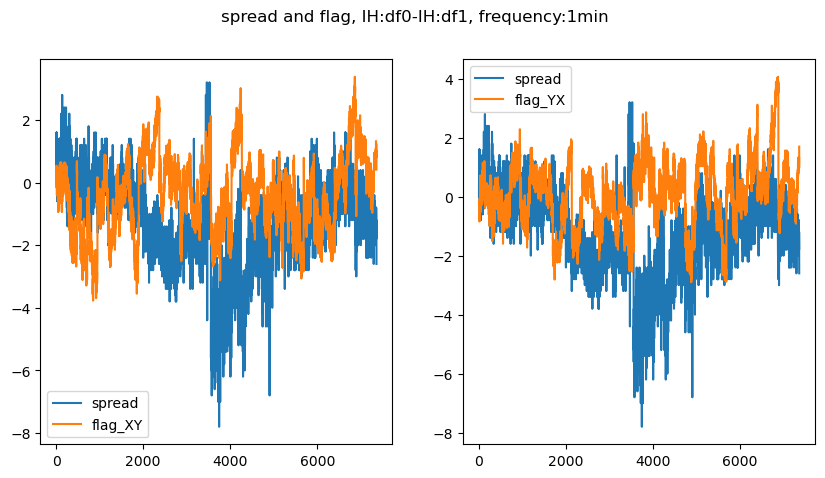

In [23]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(spread, label='spread')
ax[0].plot(aPair.flag_XY, label='flag_XY')
ax[0].legend()
ax[1].plot(spread, label='spread')
ax[1].plot(aPair.flag_YX, label='flag_YX')
ax[1].legend()
plt.suptitle(f'spread and flag, {contract_pair}, frequency:{freq}')

## Moving average and use idea similar to that of bollinger bands

1. test for stationarity (conclusion: not always valid)

2. Question: Pr(X|Y)  Pr(Y|X) are they symmetric? 
   intuitively, they should be
3. When X is overpriced, short spread (X-Y)
4. When Y is overpriced, long spread (X-Y)

In [24]:
from rosettastone.utils.utils import adf_test, kpss_test
print('Testing flag_XY')
adf_test(aPair.flag_XY)  #type: ignore
kpss_test(aPair.flag_XY)
print('Testing flag_YX')
adf_test(aPair.flag_YX)
kpss_test(aPair.flag_YX)
print('Testing spread')
adf_test(spread)
kpss_test(spread)

Testing flag_XY
------------------------------
ADF Statistic: -5.557877
p-value: 0.000002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
we can reject the null hypothesis
Verdict: Stationary likely!
********************************
Results of KPSS Test:
Null Hypothesis: The series is stationary
Test Statistic            0.866888
p-value                   0.010000
Lags Used                53.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Result: The series is not stationary
Testing flag_YX
------------------------------
ADF Statistic: -5.846388
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
we can reject the null hypothesis
Verdict: Stationary likely!
********************************
Results of KPSS Test:
Null Hypothesis: The series is stationary
Test Statistic            1.173915
p-value                   0.010000
Lags Used                53

/Users/stellarmonster/Documents/Work/BackTesting/rosettastone/utils/utils.py:335: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/Users/stellarmonster/Documents/Work/BackTesting/rosettastone/utils/utils.py:335: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/Users/stellarmonster/Documents/Work/BackTesting/rosettastone/utils/utils.py:335: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [25]:
from rosettastone.algos.arbitrage.meanreversion import get_bollingerband_cross
df_f_x_y = get_bollingerband_cross(df_1.market_time, aPair.flag_XY, window=20, upper=2, lower=2)
df_f_y_x = get_bollingerband_cross(df_1.market_time, aPair.flag_YX, window=20, upper=2, lower=2)

In [27]:
df_f_y_x['cross'].value_counts()

cross
 0    6872
 1     247
-1     243
Name: count, dtype: int64

In [28]:
# short_spread and long spread
direction_trading_spread = -1*np.sign(df_f_x_y.cross - df_f_y_x.cross)

In [29]:
direction_trading_spread.value_counts()

cross
 0    6511
-1     433
 1     418
Name: count, dtype: int64

In [38]:

# # save intermediate results for comparison
# data_ = {
#          'market_time':df_1.market_time,
#          'flag_XY':aPair.flag_XY, 
#          'flag_YX':aPair.flag_YX,
#          'spread': spread,
#          'signal': direction_trading_spread
# }
# df_trading_ori = pd.DataFrame(data=data_)
# df_trading_ori.to_csv(f'result_trading_signal.{contract_pair}.{freq}.csv', sep=',', index=False)

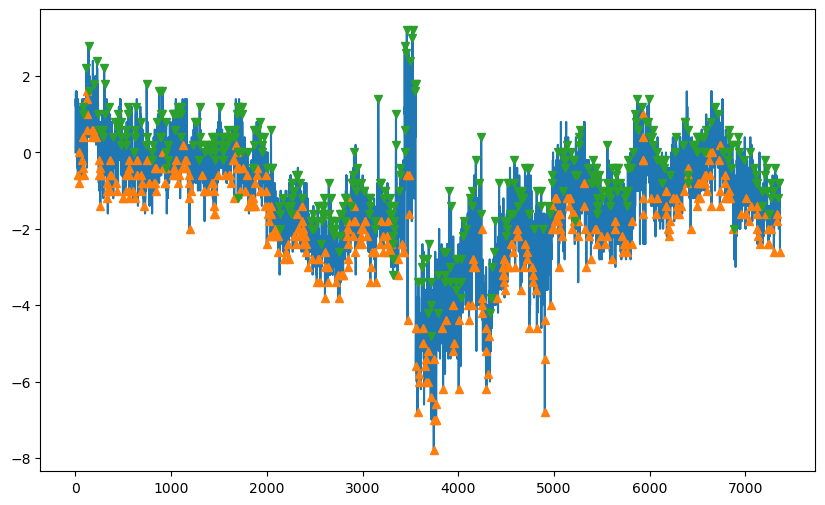

In [30]:
fig = plt.subplots(figsize=(10, 6))
idx_buy = np.where(direction_trading_spread==1)[0]
idx_sell = np.where(direction_trading_spread==-1)[0]
plt.plot(spread)
plt.plot(idx_buy, spread[idx_buy], '^', label='buy')
plt.plot(idx_sell, spread[idx_sell], 'v', label= 'sell')

In [31]:
import plotly.graph_objects as go
fig = go.Figure() #type:ignore
fig.add_trace(go.Scatter(x=df_1.market_time, 
                         y=spread, name=f'{contract_1}-{contract_2}')) #type:ignore
fig.add_trace(go.Scatter(x=df_1.market_time.iloc[idx_buy], y=spread[idx_buy], #type:ignore
               mode='markers',marker=dict(size=8, symbol="triangle-up"))) 
fig.add_trace(go.Scatter(x=df_1.market_time.iloc[idx_sell], y=spread[idx_sell], #type:ignore
                mode='markers',marker=dict(size=8, symbol="triangle-down"))
                         )

fig.update_xaxes(rangeslider_visible=True, # type:ignore
                 rangebreaks=[
                                dict(bounds=['sat', 'mon']), 
                                dict(bounds=[15, 9.5], pattern='hour'),
                                dict(bounds=[11.5, 13], pattern='hour')]
                 )

fig.update_layout(title=f'spread {contract_1}-{contract_2}')

fig.show()

/var/folders/ws/ssswm0_s1jzfrmd0bbpbyg5c0000gn/T/ipykernel_25402/1277466388.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ws/ssswm0_s1jzfrmd0bbpbyg5c0000gn/T/ipykernel_25402/1277466388.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Pairs trading with side signal, running now..


100%|██████████| 7362/7362 [00:00<00:00, 84980.83it/s]


calculating pnl..


100%|██████████| 757/757 [00:00<00:00, 228357.89it/s]


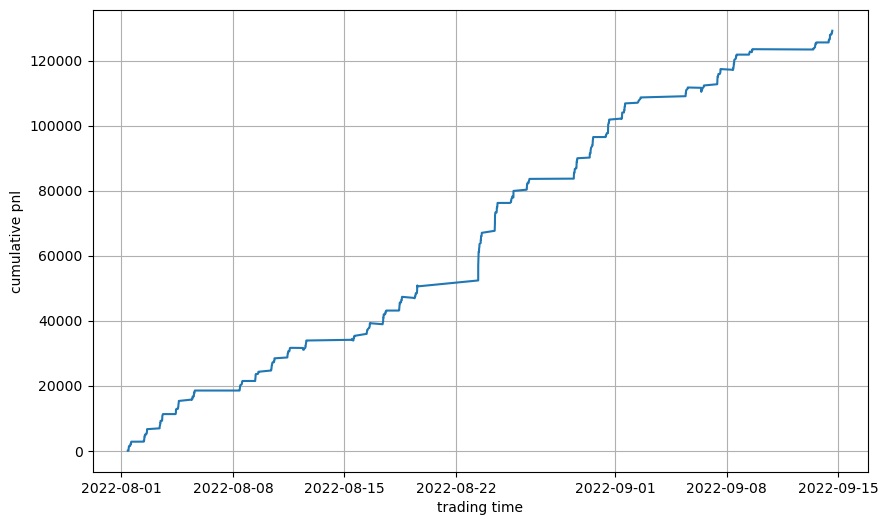

In [32]:
from rosettastone.trade import bot
contract_a = df_1[['market_time', 'close']]
contract_b = df_2[['market_time', 'close']]
contract_a.rename(columns={'close': 'price'}, inplace=True)
contract_b.rename(columns={'close': 'price'}, inplace=True)
spread_ = pd.DataFrame({'market_time':df_1.market_time, 'price': spread})
trades = bot.trade_spread(spread_, contract_a, contract_b, direction_trading_spread)
plt.figure(figsize=(10, 6))
plt.plot(trades.time, trades.cum_pnl)
plt.xlabel('trading time')
plt.ylabel('cumulative pnl')
plt.grid()

## Performance Metrics

Need bring up the module to calculate more performance metrics:
* Sharpe Ratio
* Calmar Ratio
* Maximum Drawdown
* Maximum Drawdown Duration
* Min/Max Daily Returns
* Average Daily Return
* Holding Periods
* Profit/Loss Ratio
* Win/Loss Ratio
* Maximum Funds Required
* Transaction Costs (slippage, commission, fees) -- percentage of profits

### Trading Logic Variations

* We may change the opening and closing (especially the closing condition)
  - close when the misprice index reaches zero 

## Vine Copula for Multiple Contracts 

Example: [Statistical arbitrage with vine copulas, 2016](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf)

* One target stock
* Three partner stock
* Higher dimensional partner portfolio will lead to higher performance